## **Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
import pandas as pd

jams_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/annotation"

OPEN_STRING_MIDI = {
    6: 40,  # E2
    5: 45,  # A2
    4: 50,  # D3
    3: 55,  # G3
    2: 59,  # B3
    1: 64,  # E4
}

In [3]:
!pip install numpy==1.24.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 96.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is 

In [2]:
!pip install jams librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 4.3 MB/s eta 0:00:00
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64900 sha256=068d95f0cb193826b8c8f3aae7533944ebb58ff257889da0fae114f13c2899f0
  Stored in directory: /root/.cache/pip/wheels/3e/b9/4f/64010f7e4412ba5c6190fe04ce93487970f4ae967c952b1460
Successfully built jams


In [3]:
import jams
import numpy as np
import librosa

## **Feature Extraction**

In [4]:
def get_fret_string_candidates(midi_note):
    candidates = []
    for string, open_midi in OPEN_STRING_MIDI.items():
        fret = midi_note - open_midi
        if 0 <= fret <= 24:
            freq = librosa.midi_to_hz(open_midi + fret)
            candidates.append((string, fret, round(freq, 2)))
    return candidates


In [5]:
def match_fret_string(freq, candidates):
    best_match = None
    min_diff = float("inf")
    for string, fret, target_freq in candidates:
        diff = abs(target_freq - freq)
        if diff < min_diff:
            min_diff = diff
            best_match = (string, fret, target_freq)
    return best_match


In [10]:
results = []

for fname in sorted(os.listdir(jams_dir)):
    if fname.endswith(".jams"):
        jam_path = os.path.join(jams_dir, fname)
        jam = jams.load(jam_path)

        for ann in jam.annotations:
            if ann.namespace == "note_midi":
                for note in ann.data:
                    midi_note = round(note.value)
                    start = note.time
                    end = start + note.duration

                    pitch_freqs = []
                    for ann2 in jam.annotations:
                        if ann2.namespace == "pitch_contour":
                            for pitch in ann2.data:
                                if pitch.time >= start and pitch.time <= end and pitch.value["voiced"]:
                                    pitch_freqs.append(pitch.value["frequency"])

                    if pitch_freqs:
                        avg_freq = np.mean(pitch_freqs)
                        candidates = get_fret_string_candidates(midi_note)
                        match = match_fret_string(avg_freq, candidates)
                        if match:
                            string, fret, target_freq = match
                            results.append({
                                "filename": fname,
                                "note_midi": midi_note,
                                "avg_freq": round(avg_freq, 2),
                                "matched_string": string,
                                "matched_fret": fret,
                                "matched_freq": target_freq
                            })

In [19]:
df_results = pd.DataFrame(results)
df_results.to_csv("/content/drive/MyDrive/Automatic Guitar Transcription/feature_extraction/fret_string_inference_by_freq/fret_string_inference_results.csv", index=False)
df_results.head()

,filename,note_midi,avg_freq,matched_string,matched_fret,matched_freq
0,00_BN1-129-Eb_comp.jams,44,231.66,6,4,103.83
1,00_BN1-129-Eb_comp.jams,44,225.59,6,4,103.83
2,00_BN1-129-Eb_comp.jams,44,220.32,6,4,103.83
3,00_BN1-129-Eb_comp.jams,46,141.34,6,6,116.54
4,00_BN1-129-Eb_comp.jams,46,228.37,6,6,116.54


## **Inspect Results**

In [13]:
import pandas as pd

df_results = pd.DataFrame(results)

summary = {
    "total_notes": len(df_results),
    "unique_files": df_results['filename'].nunique(),
    "string_usage": df_results['matched_string'].value_counts().sort_index().to_dict(),
    "fret_range": (df_results['matched_fret'].min(), df_results['matched_fret'].max()),
    "avg_fret": round(df_results['matched_fret'].mean(), 2),
    "most_common_fret": df_results['matched_fret'].mode().iloc[0]
}

print("📊 Summary:")
for k, v in summary.items():
    print(f"{k}: {v}")

📊 Summary:
total_notes: 62476
unique_files: 360
string_usage: {2: 13, 3: 484, 4: 3789, 5: 10330, 6: 47860}
fret_range: (0, 24)
avg_fret: 16.88
most_common_fret: 20


In [14]:
import pandas as pd

# 🎯 Fret-string eşleşme sonuçlarını DataFrame'e aktar
df_results = pd.DataFrame(results)

# 🔍 İlk 20 satırı gör
print("📋 First 20 rows of inference results:")
print(df_results.head(20))

# 📊 Özet istatistikler
print("\n📊 Summary statistics:")
print(f"Total Notes: {len(df_results)}")
print(f"Unique Files: {df_results['filename'].nunique()}")
print("String Usage:", df_results['matched_string'].value_counts().sort_index().to_dict())
print(f"Fret Range: {df_results['matched_fret'].min()} – {df_results['matched_fret'].max()}")
print(f"Average Fret: {round(df_results['matched_fret'].mean(), 2)}")
print(f"Most Common Fret: {df_results['matched_fret'].mode().iloc[0]}")

📋 First 20 rows of inference results:
                   filename  note_midi  avg_freq  matched_string  \
0   00_BN1-129-Eb_comp.jams         44    231.66               6   
1   00_BN1-129-Eb_comp.jams         44    225.59               6   
2   00_BN1-129-Eb_comp.jams         44    220.32               6   
3   00_BN1-129-Eb_comp.jams         46    141.34               6   
4   00_BN1-129-Eb_comp.jams         46    228.37               6   
5   00_BN1-129-Eb_comp.jams         44    226.33               6   
6   00_BN1-129-Eb_comp.jams         44    189.03               6   
7   00_BN1-129-Eb_comp.jams         51    267.23               6   
8   00_BN1-129-Eb_comp.jams         51    183.70               6   
9   00_BN1-129-Eb_comp.jams         51    249.41               6   
10  00_BN1-129-Eb_comp.jams         51    258.49               6   
11  00_BN1-129-Eb_comp.jams         51    217.27               6   
12  00_BN1-129-Eb_comp.jams         51    278.16               6   
13  00_BN1

<ipython-input-15-7b5947a34d66>:9: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


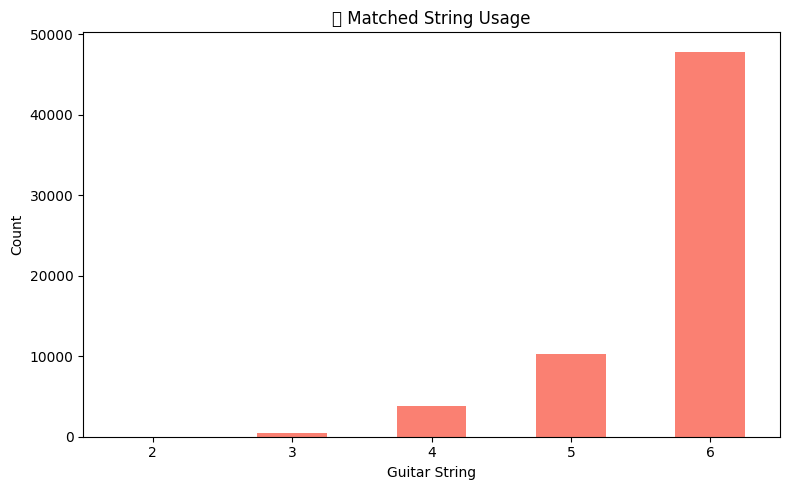

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
df_results['matched_string'].value_counts().sort_index().plot(kind='bar', color='salmon')
plt.title("🎸 Matched String Usage")
plt.xlabel("Guitar String")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<ipython-input-16-0c011533bf45>:7: UserWarning: Glyph 127898 (\N{LEVEL SLIDER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127898 (\N{LEVEL SLIDER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


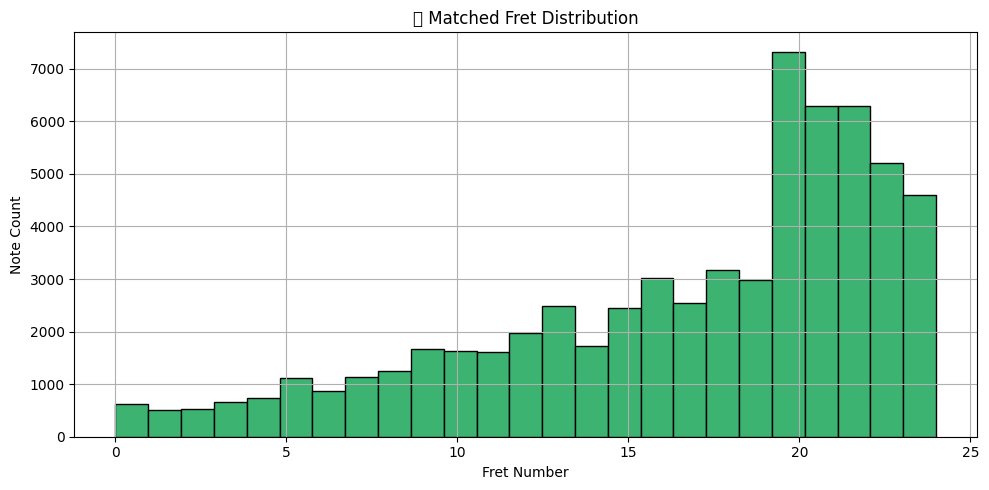

In [16]:
plt.figure(figsize=(10, 5))
df_results['matched_fret'].plot(kind='hist', bins=25, color='mediumseagreen', edgecolor='black')
plt.title("🎚️ Matched Fret Distribution")
plt.xlabel("Fret Number")
plt.ylabel("Note Count")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-17-816f37f132a0>:9: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


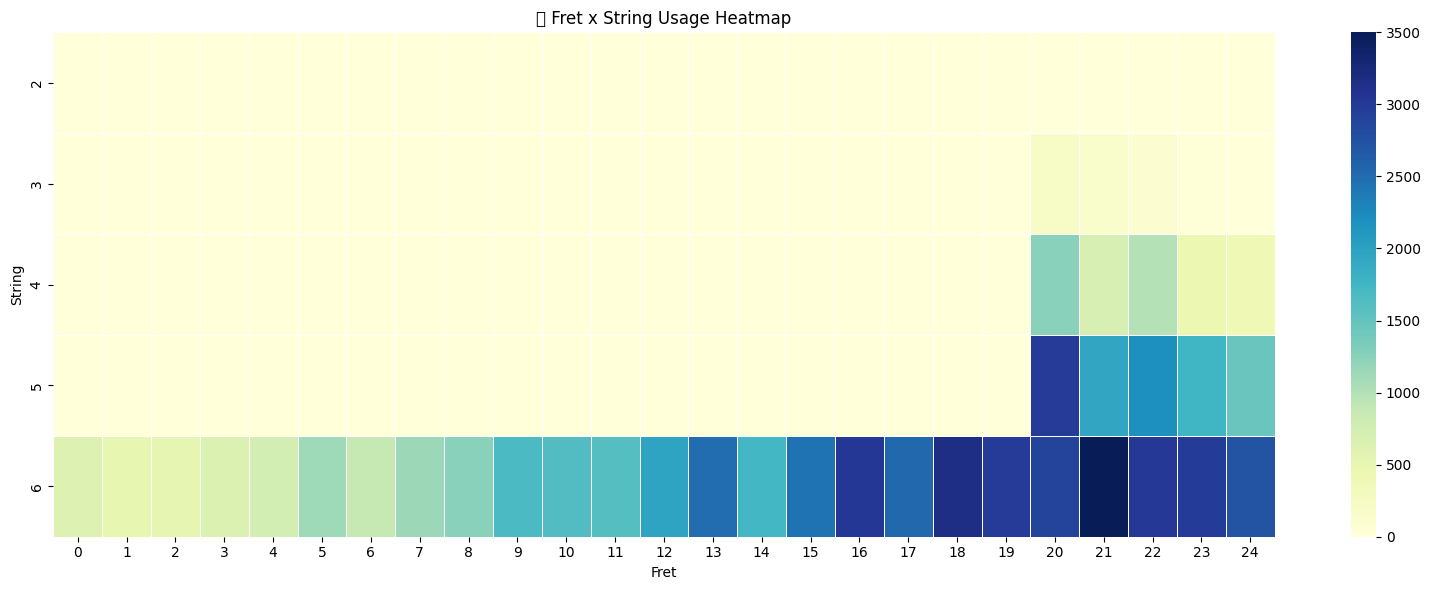

In [17]:
import seaborn as sns
pivot = df_results.pivot_table(index='matched_string', columns='matched_fret', aggfunc='size', fill_value=0)

plt.figure(figsize=(16, 6))
sns.heatmap(pivot, cmap="YlGnBu", linewidths=0.5)
plt.title("🎯 Fret x String Usage Heatmap")
plt.xlabel("Fret")
plt.ylabel("String")
plt.tight_layout()
plt.show()


<ipython-input-18-b5c8974d6b55>:9: UserWarning: Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128193 (\N{FILE FOLDER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


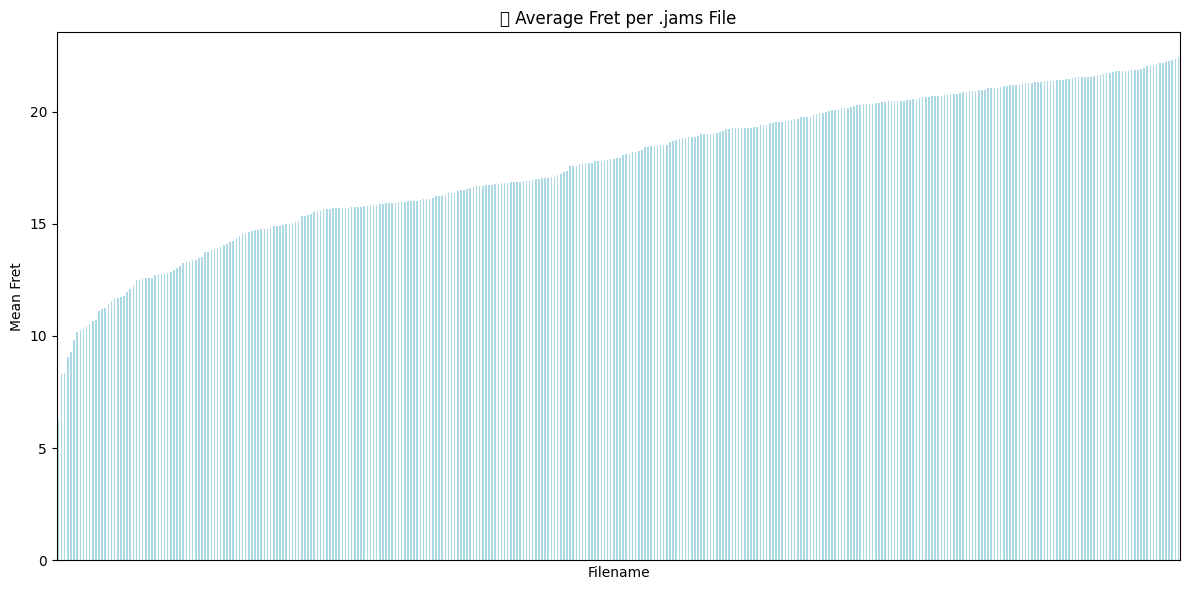

In [18]:
mean_fret_per_file = df_results.groupby("filename")["matched_fret"].mean()

plt.figure(figsize=(12, 6))
mean_fret_per_file.sort_values().plot(kind="bar", color="lightblue")
plt.title("📁 Average Fret per .jams File")
plt.xlabel("Filename")
plt.ylabel("Mean Fret")
plt.xticks([], [])  # Yalnızca barları göster, eksenleri temizle
plt.tight_layout()
plt.show()
